In [51]:
import matplotlib.gridspec as gridspec
from deepfly.CameraNetwork import CameraNetwork
from deepfly.Config import config_h36m as config
from deepfly.os_util import *
from deepfly.plot_util import *
from deepfly.signal_util import *
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('dark_background')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
plt.style.use('dark_background')

c = cam_id = 1
image_folder = '../data/h3.6m/'
image_folder = os.path.abspath(image_folder)
output_folder = '/home/user/Desktop/h36m_test/'

d = np.load(glob.glob(os.path.join(image_folder, 'pose_result*.pkl'))[0])
points2d = d["points2d"][cam_id]
points2d = smooth_pose2d(points2d)
pts3d = d["points3d"]

skeleton = config["skeleton"]
calib = read_calib(image_folder)
_, cid2cidread = read_camera_order(image_folder)
camNet = CameraNetwork(image_folder=image_folder, calibration=calib, cam_id_list=range(config["num_cameras"]), cid2cidread=cid2cidread)

# prepare 3d plot data
pts_t = filter_batch(pts3d.copy())
tmp = pts_t[:,:,1].copy()
pts_t[:,:,1] = pts_t[:,:,2].copy()
pts_t[:,:,2] = tmp
pts_t[:,:,2] *=-1 
pts_t[:,:,1] *=-1 
pts_t = normalize_pose_3d(pts_t, normalize_median=True)

# prepare the angle data
data = pts3d.copy()
data_angle  = pose3d_to_angle(data, skeleton)

Loading predictions ['/home/user/Desktop/DeepFly3D/data/h3.6m/preds_-home-user-Desktop-DeepFly3D-data-h3.6m.pkl']
Loading heatmaps ['/home/user/Desktop/DeepFly3D/data/h3.6m/heatmap_-home-user-Desktop-DeepFly3D-data-h3.6m.pkl']
Heatmap shape: (5, 101, 16, 128, 128)


0
50


<Figure size 3888x1800 with 0 Axes>

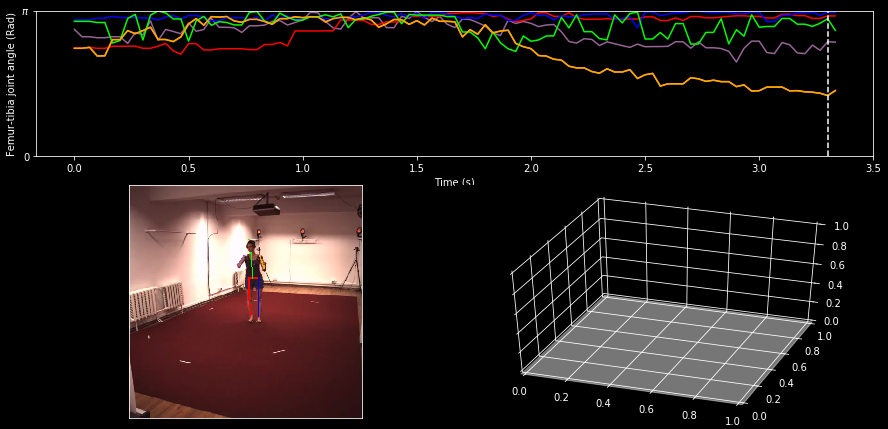

In [55]:
num_rows, num_cols = 5, 6
joints_to_draw = [11,14, 1, 4 ,7,14]
colors = [skeleton.colors[skeleton.get_limb_id(j)] for j in joints_to_draw]
colors = [(c[0]/255., c[1]/255., c[2]/255.) for c in colors]
zorder = skeleton.get_zorder(cam_id)
thickness = [config["line_thickness"]]*skeleton.num_limbs

fig = plt.figure(figsize=(num_cols*9,num_rows*5))

gs1 = gridspec.GridSpec(num_rows, num_cols)
gs1.update(wspace=0, hspace=0.5) 

plt.figure(figsize=(15,7.5))

ax1 = plt.subplot(gs1[:2,:])
ax2 = plt.subplot(gs1[2:,:3])
ax3 = plt.subplot(gs1[2:,3:], projection='3d')

ax2_set_data = ax2.imshow(camNet[cam_id].plot_2d(img_id=0))
ax2.set_xticks([])
ax2.set_yticks([])

img_id_list = range(0, 100)

for img_id in img_id_list:
    if img_id%50==0:
        print(img_id)    
    ax1.clear()
    draw_time_series(ax1, np.squeeze(data_angle[:,[joints_to_draw]]), tick=img_id, segmentation=None, show_activation=False, colors_time=colors, fps=30, bias=0)
    ax2_set_data.set_data(camNet[cam_id].plot_2d(img_id=img_id, pts=points2d[img_id], zorder=zorder, thickness=thickness))
    
    c = cam_id = 1
    points3d = pts_t[img_id,:,:]
    ang = -90 - (camNet[c].rvec[1]*57.2)
    period = 360 # frames
    extend = 20
    ang_move = np.sin(2*np.pi*((img_id)/period))*extend
    ang += ang_move
    
    ax3.elev = 40
    zorder = skeleton.get_zorder(c)
    plot_drosophila_3d(ax_3d=ax3, points3d=pts_t[img_id,:], cam_id=c, ang=ang, zorder=zorder, colors=skeleton.colors)
    plt.savefig(os.path.join(output_folder, f'time_series_{img_id}.png'), figsize=(40,20), dpi=160, bbox_inches = 'tight')
    ax3.cla()